In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
N = 100 #capes
dt = 0.001 #delta t
maxtemps = 740 #nombre de dt's
T = [0] #np.linspace(0, maxtemps*dt, maxtemps+1)
beta = 0.5
R_0 = 1e4
d_0 = 1e7 #densitat inicial
M =  4/3*np.pi*d_0*(R_0)**3 #massa total
dm = M/N #massa per capa
G = 6.674e-8 #constant de gravitacio
tol = 1e-4

d = np.full((1, N), d_0, dtype = float) #densitat
r = np.full((1, N+1), 0, dtype = float) #radis
u = np.full((1, N+1), 0, dtype = float) #velocitats
#radis inicials
for i in range(1, N + 1):
    r[0, i] = np.cbrt(3*dm/(4*np.pi*d_0) + r[0, i-1]**3)

In [22]:
def C(n):
    C1=1/d[n+1,0] - 4/3*np.pi*(r[n+1,1]**3)/dm
    C2=(u[n+1, 1] - u[n, 1])/dt - (1-beta)*(-G*dm/(r[n,1])**2) - beta*(-G*dm/(r[n+1,1]**2))
    C3=(r[n+1, 1] - r[n,1])/dt - (1-beta)*u[n,1] - beta*u[n+1,1]  
    return [C1, C2, C3]
 
def F(n, i): # i va de 1 fins N-2
    F1 = 1/d[n+1, i] - 4/3*np.pi*(r[n+1, i+1]**3 - r[n+1, i]**3)/dm
    F2 = (u[n+1, i+1] - u[n, i+1])/dt + (1-beta)*(G*(i+1)*dm)/(r[n, i+1]**2) + beta*(G*(i+1)*dm)/(r[n+1, i+1]**2)
    F3 = (r[n+1, i+1] - r[n, i+1])/dt - (1-beta)*u[n, i+1] - beta*u[n+1, i+1]
    return [F1, F2, F3]
 
def S(n):
    S1=1/(d[n+1,N-1]) - 4/3*np.pi*(r[n+1, N]**3 - r[n+1, N-1]**3)/dm
    S2=(u[n+1, N] - u[n, N])/dt - (1-beta)*(-G*M/r[n,N]**2) - beta*(-G*M/(r[n+1, N]**2))
    S3=(r[n+1, N] - r[n,N])/dt - (1-beta)*u[n, N]-beta*u[n+1, N]
    return [S1, S2, S3]

In [23]:
def dC1dd(n):
    return -1/(d[n+1, 0]**2)
def dC1dr(n):
    return -4*np.pi*r[n+1, 1]**2/dm
def dC2dr(n):
    return -2*beta*G*dm/(r[n+1, 1]**3)
def dC2du(n):
    return 1/dt
def dC3dr(n):
    return 1/dt
def dC3du(n):
    return -beta

#i és el de F
#ii es el de la derivada
def dF1dd(n, i):
    return -1/(d[n+1,i]**2)
def dF1dr(n, i, ii):
    if (i==ii):
        return 4*np.pi*(r[n+1, i]**2)/dm
    else:
        return -4*np.pi*(r[n+1, ii]**2)/dm
def dF2du(n,i):
    return 1/dt
def dF2dr(n, i):
    return -beta*2*G*dm*(i+1)/(r[n+1, i+1]**3) 
def dF3dr(n, i):
    return 1/dt 
def dF3du(n, i):
    return -beta

def dS1dd(n):
    return -1/(d[n+1, N-1]**2)
def dS1dr(n, ii):
    if ii == N-1:
        return 4*np.pi*r[n+1, N-1]**2/dm
    else:
        return -4*np.pi*r[n+1, N]**2/dm
def dS2dr(n):
    return -2*beta*G*M/(r[n+1, N]**3)
def dS2du(n):
    return 1/dt
def dS3dr(n):
    return 1/dt
def dS3du(n):
    return -beta

In [24]:
#main
for n in range (0, maxtemps):
    d = np.append(d, [d[-1, :]], axis=0)
    r = np.append(r, [r[-1, :]], axis=0)
    u = np.append(u, [u[-1, :]], axis=0)
    e = 1.0
    e_ant = 100.0
    T.append(T[-1] + dt)
    
    while (e >= tol):
        B = np.full((N, 3), 0, dtype = float)
        #interior
        A = np.array([[dC1dd(n), dC1dr(n), 0], [0, dC2dr(n), dC2du(n)], [0, dC3dr(n), dC3du(n)]])
        c = -np.array(C(n))
        B[0] = np.linalg.solve(A, c)
        #intermig
        for i in range(1, N-1):
            A = np.array([[dF1dd(n, i), dF1dr(n, i, i+1), 0], [0, dF2dr(n, i), dF2du(n, i)], [0, dF3dr(n, i), dF3du(n, i)]])
            c = -np.array(F(n, i))- np.array([dF1dr(n, i, i)*B[i-1, 1], 0, 0])
            B[i] = np.linalg.solve(A, c)
        #final
        A = np.array([[dS1dd(n), dS1dr(n, N), 0], [0, dS2dr(n), dS2du(n)], [0, dS3dr(n), dS3du(n)]])
        c = -np.array(S(n))- np.array([dS1dr(n, N -1)*B[N-2, 1], 0, 0])
        B[N-1] = np.linalg.solve(A, c)

        B = np.transpose(B)
        #calculem l'error
        e = max(np.append(np.append(np.divide(B[0], d[-1] + B[0]), np.divide(B[1], r[-1][1:] + B[1])),
                          np.divide(B[2], u[-1][1:] + B[2])))
        #per que no passin coses rares
        #if (e > e_ant): continue
        #sumem
        d[-1] = d[-1] + B[0]
        r[-1][1:] = r[-1][1:] + B[1]
        u[-1][1:] = u[-1][1:] + B[2]
        e_ant = e
        #print(n, e)
    if T[-1] >= 0.66:
        dt= 0.0001
    if T[-1] >= 0.664:
        dt = 0.00005
#print(r)

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


LinAlgError: Singular matrix

beta =  0.5, N = 100 shells


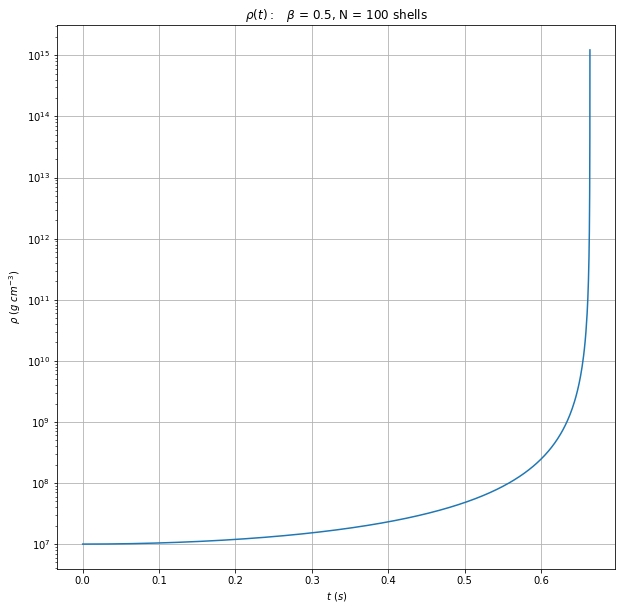

In [26]:
plt.figure(figsize = (10, 10))
plt.semilogy(T[:-1], d[:-1, -1], basey=10)
plt.grid(True)
plt.xlabel(r'$t$ $(s)$')
plt.ylabel(r'$\rho$ $(g$ $cm^{-3})$')
s = str(beta) + ', N = ' + str(N) + ' shells'
print('beta = ',s)
plt.title(r'$\rho(t):$   $\beta$ = '+s)
#plt.text(8e-10, 0.3, s, fontsize=12)
plt.savefig('rhot_N100_b0.png')
plt.show()

beta =  0.5, N = 100 shells


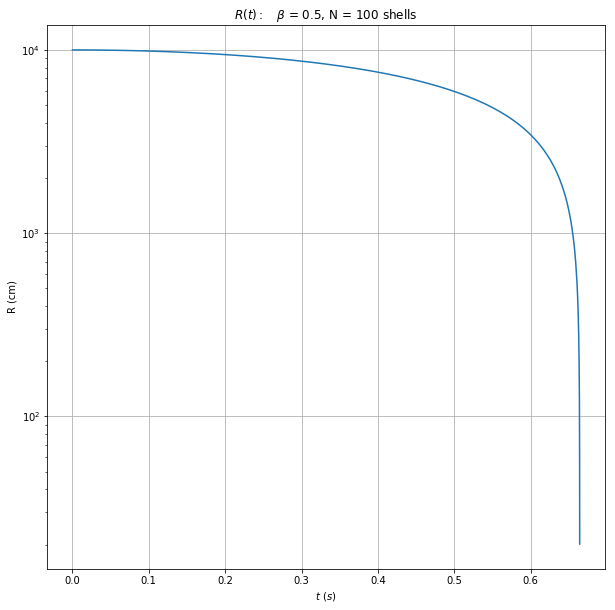

In [27]:
plt.figure(figsize = (10, 10))
plt.semilogy(T[:-1], r[:-1, -1], basey=10)
plt.grid(True)
plt.xlabel(r'$t$ $(s)$')
plt.ylabel('R (cm)')
s = str(beta) + ', N = ' + str(N) + ' shells'
print('beta = ',s)
plt.title(r'$R(t):$   $\beta$ = '+s)
#plt.text(8e-10, 0.3, s, fontsize=12)
plt.savefig('Rt_N100_b0.png')
plt.show()

In [8]:
for i in range(500, len(T)):
    print(T[i], r[i, -1], d[i, -1])

In [9]:
atomar = [0, 500, 600, 650, 675, 685, 695, 700, 703, 705] #posicions a plotejar
tplt = np.array(T)[atomar]
hori = []
veri = []
for i in atomar:
    a = np.log10(r[i, -1]); b = np.log10(d[i, -1])
    hori.append([0, a]); hori.append([b, b])
    veri.append([a, a]); veri.append([0, b])

plt.figure(figsize=(10, 10))
plt.axes()

for i in range(len(hori)//2):
    line1 = plt.Line2D(hori[2*i], hori[2*i+1], lw=1, color = 'black')
    line2 = plt.Line2D(veri[2*i], veri[2*i+1], lw=1, color = 'black')
    plt.gca().add_line(line1)
    plt.gca().add_line(line2)
    s = 't = '+ str(float("{0:.5f}".format(tplt[i])))+' s'
    plt.text(0.3, hori[2*i + 1][0]+ 0.05, s, fontsize=12)
#x
plt.xlim(0, 5)
xlabels = []
for i in range(0, 51):
    if (i%10 == 0): xlabels.append(str(i//10))
    else: xlabels.append(' ')
plt.xticks(np.arange(0, 5.1, 0.1), xlabels)

#y
plt.ylim(6, 16)
ylabels = []
for i in range(0, 61):
    if (i%10 == 0): ylabels.append(str(6 + 2*i//10))
    else: ylabels.append(' ')
plt.yticks(np.arange(6, 16.2, 0.2), ylabels)
plt.xlabel(r'$Log R$ $(cm)$')
plt.ylabel(r'$Log \rho$ $(g$ $cm^{-3})$')
#plt.axis('scaled')
s = str(beta) + ', N = ' + str(N) + ' shells'
plt.title(r'$\rho$ as a function of r and time: $\beta$ = '+s )
plt.savefig('dRt_N100_b0.png')
plt.show()

IndexError: index 500 is out of bounds for axis 0 with size 496

In [25]:
T[450:]

[0.45000000000000034,
 0.45100000000000035,
 0.45200000000000035,
 0.45300000000000035,
 0.45400000000000035,
 0.45500000000000035,
 0.45600000000000035,
 0.45700000000000035,
 0.45800000000000035,
 0.45900000000000035,
 0.46000000000000035,
 0.46100000000000035,
 0.46200000000000035,
 0.46300000000000036,
 0.46400000000000036,
 0.46500000000000036,
 0.46600000000000036,
 0.46700000000000036,
 0.46800000000000036,
 0.46900000000000036,
 0.47000000000000036,
 0.47100000000000036,
 0.47200000000000036,
 0.47300000000000036,
 0.47400000000000037,
 0.47500000000000037,
 0.47600000000000037,
 0.47700000000000037,
 0.47800000000000037,
 0.47900000000000037,
 0.48000000000000037,
 0.48100000000000037,
 0.4820000000000004,
 0.4830000000000004,
 0.4840000000000004,
 0.4850000000000004,
 0.4860000000000004,
 0.4870000000000004,
 0.4880000000000004,
 0.4890000000000004,
 0.4900000000000004,
 0.4910000000000004,
 0.4920000000000004,
 0.4930000000000004,
 0.4940000000000004,
 0.4950000000000004,
 0

In [ ]:
print(d.shape)
plt.figure(figsize = (10, 10))
ratio = np.divide((np.max(d[:-3], axis= 1)- np.min(d[:-3], axis = 1)),np.mean(d[:-3], axis= 1))
#print(ratio)
plt.plot(T[:-3], ratio)
plt.xlabel('t (s)')
plt.ylabel(r'$E_r(\rho)$')
plt.title('Difference from constant density')
plt.savefig('d_error.png')
plt.show()

AQUI PASAMOS A DIFERENTES BETAS

In [15]:
df0 = pd.read_csv('beta0.csv', index_col=0)
df25 = pd.read_csv('beta25.csv', index_col=0)
df50 = pd.read_csv('beta50.csv', index_col=0)
df75 = pd.read_csv('beta75.csv', index_col=0)
df100 = pd.read_csv('beta100.csv', index_col=0)
df100 = df100.drop(df100.index[-1])
dfs = [df0, df25, df50, df75, df100]
print(df100.shape)

(685, 4)


beta =  N = 100 shells


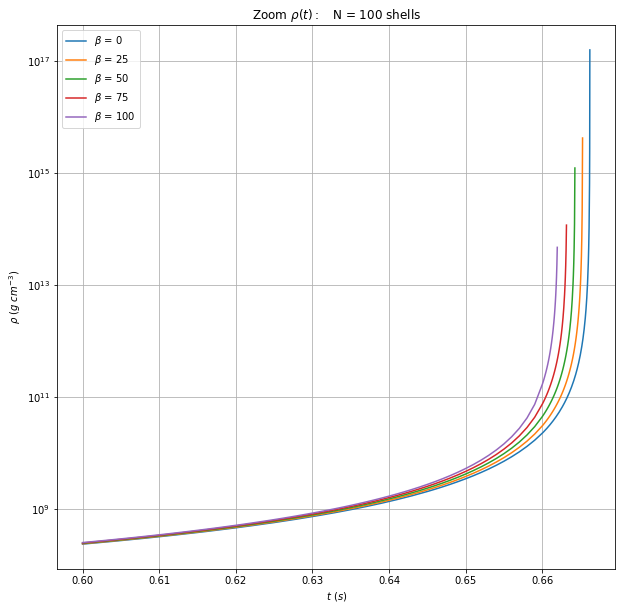

In [16]:
plt.figure(figsize = (10, 10))
for df in dfs:
    plt.semilogy(list(df['T'].loc[np.where(df['T']>0.6)]), list(df['d'].loc[np.where(df['T']>0.6)]), basey=10)
legend = [r'$\beta$ = '+str(0), r'$\beta$ = '+str(25), r'$\beta$ = '+str(50), r'$\beta$ = '+str(75), r'$\beta$ = '+str(100)]
plt.legend(legend)
plt.grid(True)
plt.xlabel(r'$t$ $(s)$')
plt.ylabel(r'$\rho$ $(g$ $cm^{-3})$')
s = 'N = ' + str(N) + ' shells'
print('beta = ',s)
plt.title(r'Zoom $\rho(t):$   '+s)
plt.savefig('dbetacomp.png')
plt.show()

beta =  N = 100 shells


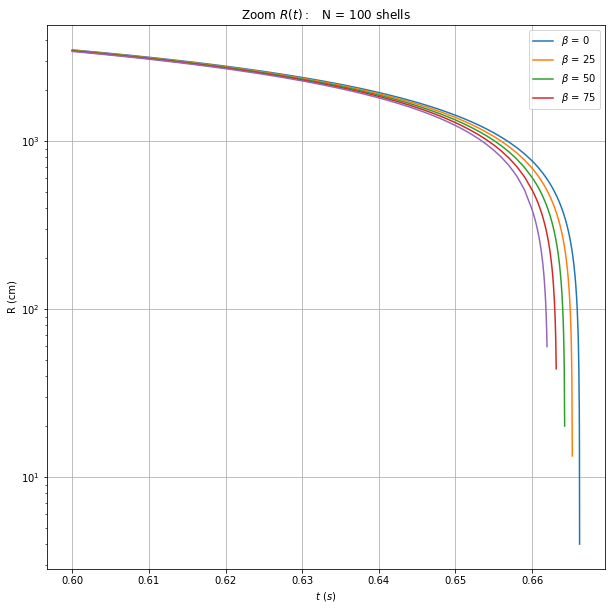

In [17]:
plt.figure(figsize = (10, 10))
for df in dfs:
    plt.semilogy(list(df['T'].loc[np.where(df['T']>0.6)]), list(df['R'].loc[np.where(df['T']>0.6)]), basey=10)
legend = [r'$\beta$ = '+str(0), r'$\beta$ = '+str(25), r'$\beta$ = '+str(50), r'$\beta$ = '+str(75)]
plt.legend(legend)
plt.grid(True)
plt.xlabel(r'$t$ $(s)$')
plt.ylabel('R (cm)')
s = 'N = ' + str(N) + ' shells'
print('beta = ',s)
plt.title(r'Zoom $R(t):$   '+s)
plt.savefig('Rbetacomp.png')
plt.show()

beta =  N = 100 shells


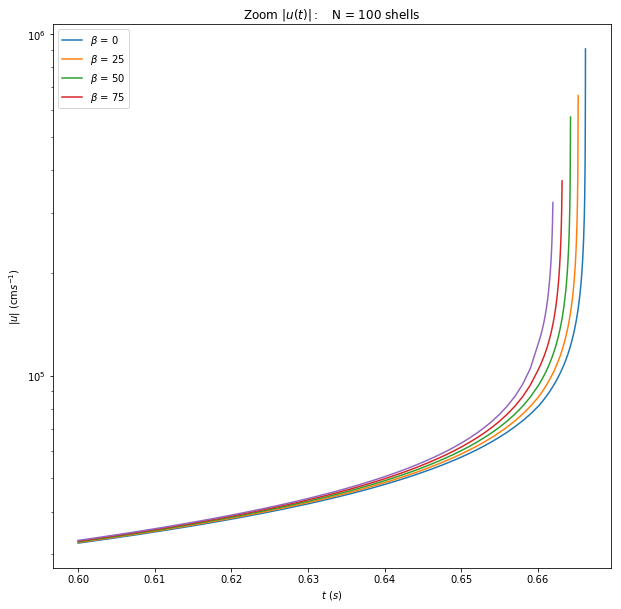

In [19]:
plt.figure(figsize = (10, 10))
for df in dfs:
    plt.semilogy(list(df['T'].loc[np.where(df['T']>0.6)]), list(-df['u'].loc[np.where(df['T']>0.6)]))
legend = [r'$\beta$ = '+str(0), r'$\beta$ = '+str(25), r'$\beta$ = '+str(50), r'$\beta$ = '+str(75)]
plt.legend(legend)
#plt.grid(True)
plt.xlabel(r'$t$ $(s)$')
plt.ylabel('$|u|$ (cm$s^{-1}$)')
s = 'N = ' + str(N) + ' shells'
print('beta = ',s)
plt.title(r'Zoom $|u(t)|:$   '+s)
plt.savefig('ubetacomp.png')
plt.show()

In [20]:
df50

,T,R,d,u
0,0.00000,10000.000000,1.000000e+07,0.000000
1,0.00100,9999.986022,1.000004e+07,-27.956025
2,0.00200,9999.944088,1.000017e+07,-55.912206
3,0.00300,9999.874197,1.000038e+07,-83.868700
4,0.00400,9999.776350,1.000067e+07,-111.825663
5,0.00500,9999.650546,1.000105e+07,-139.783251
6,0.00600,9999.496783,1.000151e+07,-167.741621
7,0.00700,9999.315062,1.000206e+07,-195.700928
8,0.00800,9999.105381,1.000268e+07,-223.661330
9,0.00900,9998.867739,1.000340e+07,-251.622983
